In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np

# Path to the dataset directory
dataset_dir = '/kaggle/input/pc-parts-images-dataset-classification/pc_parts'

# Initialize lists to store images and labels
images = []
labels = []

# # Iterate over each folder (class) in the dataset directory
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
#     print(class_dir+' '+class_name+' '+dataset_dir)
#     # Iterate over each image in the class directory
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
#         # Read the image using OpenCV
        img = cv2.imread(img_path)
#         # Append the image to the images list
        images.append(img)
#         # Append the label (class) to the labels list
        labels.append(class_name)

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# # Print the number of images and unique labels
print("Number of images:", len(images))
print("Unique labels:", np.unique(labels))

Number of images: 3279
Unique labels: ['cables' 'case' 'cpu' 'gpu' 'hdd' 'headset' 'keyboard' 'microphone'
 'monitor' 'motherboard' 'mouse' 'ram' 'speakers' 'webcam']


In [2]:
print(images.shape)

(3279, 256, 256, 3)


In [3]:
images.shape[0]

3279

In [4]:
grayscale_images=np.empty((images.shape[0],images.shape[1],images.shape[2]),dtype=np.uint8)

for i,img in enumerate(images):
    grayimage=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grayscale_images[i]=grayimage

In [5]:
print(grayscale_images.shape)

(3279, 256, 256)


In [6]:
print(labels[102])

microphone


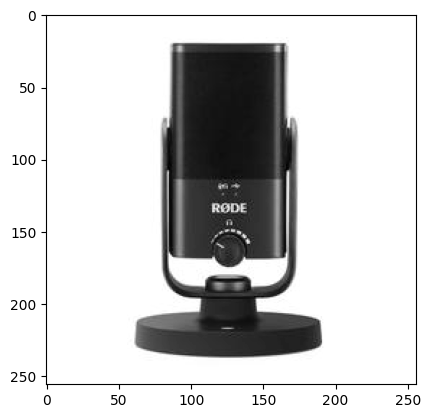

In [7]:
import matplotlib.pyplot as plt
img_plot=plt.imshow(grayscale_images[102],cmap='gray')
plt.show()

In [8]:
labels.shape

(3279,)

In [9]:
grayscale_images.shape

(3279, 256, 256)

In [10]:
def normalize_images(images):
    # Convert images to floating point
    images = images.astype('float32')
    # Normalize pixel values to [0, 1]
    images /= 255.0
    return images

# Assuming grayscale_images is a list of grayscale images represented as numpy arrays
normalized_images = normalize_images(grayscale_images)

In [11]:
normalized_images.shape

(3279, 256, 256)

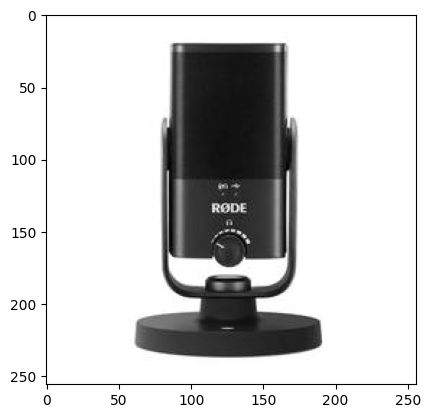

In [12]:
import matplotlib.pyplot as plt
img_plot=plt.imshow(normalized_images[102],cmap='gray')
plt.show()

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming grayscale_images and labels are already loaded

# Convert labels into numerical form
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

# Convert images to numpy array
normalized_images = np.array(normalized_images)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_images, numerical_labels, test_size=0.2, random_state=42)


# Reshape grayscale images to add channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


2024-04-07 17:42:36.360541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 17:42:36.360634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 17:42:36.484355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

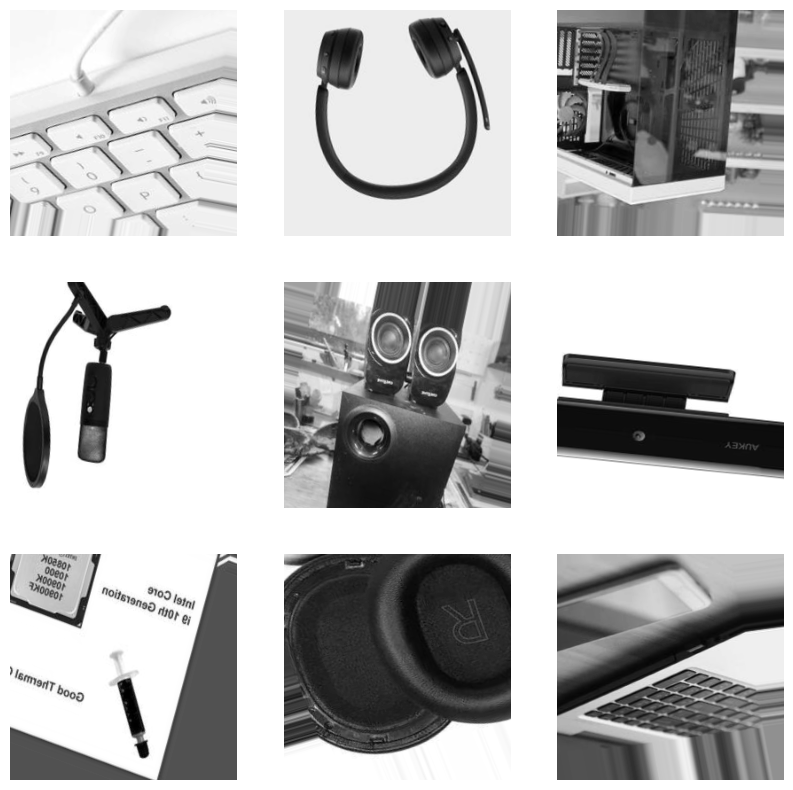

In [19]:
import matplotlib.pyplot as plt

# Generate augmented images
augmented_images, _ = next(train_generator)

# Plot augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(256, 256), cmap='gray')  # Assuming images are grayscale
    plt.axis("off")
plt.show()

In [20]:
X_train.shape[1:]

(256, 256, 1)

In [21]:
X_train.shape[1:]

# Define augmentation parameters


# Define CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(14, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Prepare data generators


# Train the model with data augmentation
model.fit(train_generator, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(X_test)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 319ms/step - accuracy: 0.0862 - loss: 3.3413 - val_accuracy: 0.1159 - val_loss: 11.7823
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.1005 - loss: 2.6150 - val_accuracy: 0.1220 - val_loss: 10.1020
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.1331 - loss: 2.5360 - val_accuracy: 0.1585 - val_loss: 9.9243
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.1539 - loss: 2.5186 - val_accuracy: 0.2195 - val_loss: 9.4840
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.1934 - loss: 2.3913 - val_accuracy: 0.1799 - val_loss: 10.0371
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.1973 - loss: 2.3825 - val_accuracy: 0.2790 - val_loss: 10.9693
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 272ms/step - accuracy: 0.2368 - loss: 2.2819 - val_accuracy: 0.2637 - val_loss: 9.9504
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - accuracy: 0.2576 - loss: 2.2376 - val_